必要なモジュールロード、使用する関数は他のファイルからロードする

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scikit_posthocs as sp
from fx import ab_t, shapiro_df, df_id

データロード

In [2]:
# read data
user = pd.read_csv("login.csv")
exp = pd.read_csv("design.csv")

ロードの後、データの全体的な状態を確認する。データを確認するの理由は、間違ったデータ、あるいは抜けているデータがあるからである。

In [3]:
# see data
print(user.describe().T)
print(user.info())
user.head()

            count  unique                   top freq
user_id    649466   12755             u00007475   67
timestamp  649466  503587  2019-06-12T03:41:28Z    7
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 649466 entries, 0 to 649465
Data columns (total 2 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   user_id    649466 non-null  object
 1   timestamp  649466 non-null  object
dtypes: object(2)
memory usage: 9.9+ MB
None


,user_id,timestamp
0,u00003805,2019-06-03T00:00:00Z
1,u00007561,2019-06-03T00:00:01Z
2,u00004822,2019-06-03T00:00:04Z
3,u00005147,2019-06-03T00:00:05Z
4,u00006390,2019-06-03T00:00:08Z


user_login.csvは、ユーザーのIDおよびユーザーのログイン時間データが含まれている。

<AxesSubplot:>

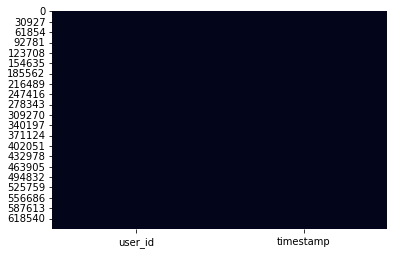

In [4]:
sns.heatmap(user.isnull(), cbar=False)

user_login.csvでは抜けているデータはない

In [5]:
print(exp.describe().T)
exp.info()

            count  mean       std  min  25%  50%  75%  max
push_cnt  11595.0   1.2  0.748364  0.0  1.0  1.0  2.0  2.0
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11595 entries, 0 to 11594
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   user_id   11595 non-null  object
 1   push_cnt  11595 non-null  int64 
 2   msg_type  11595 non-null  object
dtypes: int64(1), object(2)
memory usage: 271.9+ KB


In [6]:
exp.head(10)

,user_id,push_cnt,msg_type
0,u00000001,2,B
1,u00000002,2,B
2,u00000003,2,A
3,u00000004,0,None
4,u00000005,2,B
5,u00000006,1,B
6,u00000007,0,None
7,u00000008,1,A
8,u00000009,2,B
9,u00000010,0,None


experimental_design.csvでは、ユーザーによるメッセージやプッシュ情報がある。だが、user_login.csvではユーザーの数（１２７５５）がexperimental_design.csv（１１５９５）よりほぼ１０００件多く、併合（Join)の直後に抜けているデータが予想される。

データの最初と最後を確認する。

In [7]:
# range of timestamp variable
user.timestamp.min(), user.timestamp.max()

('2019-06-03T00:00:00Z', '2019-06-17T23:59:27Z')

experimental_design.csvはuser_login.csvと併合する。併合する理由は、各ユーザーごとにログイン時間だけでなくメッセージとプッシュの情報を結び付けないといけないためである。

In [8]:
usr_exp = user.merge(exp, how = 'left', on = 'user_id')
usr_exp

,user_id,timestamp,push_cnt,msg_type
0,u00003805,2019-06-03T00:00:00Z,2.0,A
1,u00007561,2019-06-03T00:00:01Z,1.0,B
2,u00004822,2019-06-03T00:00:04Z,2.0,B
3,u00005147,2019-06-03T00:00:05Z,1.0,B
4,u00006390,2019-06-03T00:00:08Z,1.0,A
...,...,...,...,...
649461,u00015164,2019-06-17T23:56:00Z,NaN,NaN
649462,u00021954,2019-06-17T23:56:38Z,NaN,NaN
649463,u00024042,2019-06-17T23:56:45Z,NaN,NaN
649464,u00020050,2019-06-17T23:56:47Z,NaN,NaN


<AxesSubplot:>

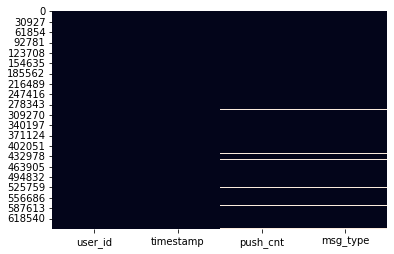

In [9]:
sns.heatmap(usr_exp.isnull(), cbar=False)

上記のグラフの黄色の線は抜けているデータを示す。

In [10]:
usr_exp.isnull().sum()

user_id          0
timestamp        0
push_cnt     32001
msg_type     32001
dtype: int64

抜けているデータが約３２０００列がある。このような場合に、代入法を適用したり全体のデータから除外する方法がある。push_cntとmsg_type変数以外に他の変数がない理由と、上記のデータが全体の５％のデータを占めるが、分析の簡素化のために抜けているデータを除去する方法で行う。

In [11]:
## filtering
# remove missing values
usr_exp = usr_exp.dropna()
# check if any rows are after 2019-06-17 and before 2019-06-03
usr_exp = usr_exp[(usr_exp['timestamp']<'2019-06-17') & (usr_exp['timestamp'] > '2019-06-02')]

抜けているデータを除去する以外にも、6/10 ~ 6/16の期間の間にログインの回数が増加したかを確認するためには、6/10から７日以前(6/3 ~ 6/9)のデータに制限する必要がある。

<AxesSubplot:>

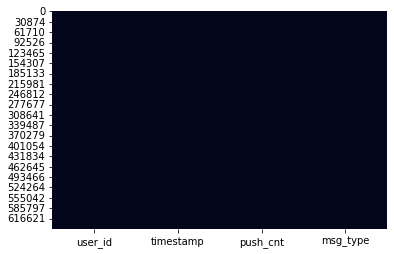

In [12]:
sns.heatmap(usr_exp.isnull(), cbar=False)

これで抜けているデータはない。次のステップに進める。

分析のためにデータの行を変換するあるいは新しい行を作ったりする。例えば、timestamp変数は施策の以前と以後に簡単に分けるためにバイナリ変数にする。なお、新しい施策は06/10から施行されたために06/10前のすべての行のpush_cntを0に変換してmsg_typeをNoneに変換する。

In [13]:
usr_exp = usr_exp.assign(push_cnt = usr_exp['push_cnt'].astype(np.int64))
usr_exp = usr_exp.assign(change = np.where(usr_exp['timestamp'] > '2019-06-10', \
    'after', 'before'))
usr_exp = usr_exp.assign(push_cnt = np.where(usr_exp['timestamp'] < '2019-06-10', \
    0, usr_exp['push_cnt']))
usr_exp = usr_exp.assign(msg_type = np.where(usr_exp['timestamp'] < '2019-06-10', \
    'None', usr_exp['msg_type']))
usr_exp = usr_exp.assign(type = usr_exp['push_cnt'].astype(str) + "/" + \
    usr_exp["msg_type"] + "/" + usr_exp["change"])

日付も別に分けてみる。

In [14]:
# time column manipulation
usr_exp = usr_exp.assign(date = pd.to_datetime(usr_exp['timestamp'].str[:10]))
usr_exp = usr_exp.assign(hour = pd.to_datetime(usr_exp['timestamp'].str[11:19]).dt.hour)
usr_exp = usr_exp.assign(day = pd.to_datetime(usr_exp['timestamp'].str[:10]).dt.day_name())

date = usr_exp.date.value_counts().to_frame().sort_index()

usr_exp

,user_id,timestamp,push_cnt,msg_type,change,type,date,hour,day
0,u00003805,2019-06-03T00:00:00Z,0,None,before,0/None/before,2019-06-03,0,Monday
1,u00007561,2019-06-03T00:00:01Z,0,None,before,0/None/before,2019-06-03,0,Monday
2,u00004822,2019-06-03T00:00:04Z,0,None,before,0/None/before,2019-06-03,0,Monday
3,u00005147,2019-06-03T00:00:05Z,0,None,before,0/None/before,2019-06-03,0,Monday
4,u00006390,2019-06-03T00:00:08Z,0,None,before,0/None/before,2019-06-03,0,Monday
...,...,...,...,...,...,...,...,...,...
647362,u00002056,2019-06-16T23:59:54Z,2,B,after,2/B/after,2019-06-16,23,Sunday
647363,u00001576,2019-06-16T23:59:55Z,0,None,after,0/None/after,2019-06-16,23,Sunday
647364,u00002597,2019-06-16T23:59:55Z,2,B,after,2/B/after,2019-06-16,23,Sunday
647365,u00003499,2019-06-16T23:59:56Z,2,B,after,2/B/after,2019-06-16,23,Sunday


上記のデータテーブル通りにデータ変換が終わった。上記データで比較的に簡単で精密な分析ができるようになる。

データを視覚化したり、希望する関数に代入するのに比較的に容易である。これからデータのトレンドやパターンなど変数の間に関係性を詳しく調査するためにEDAを行う。

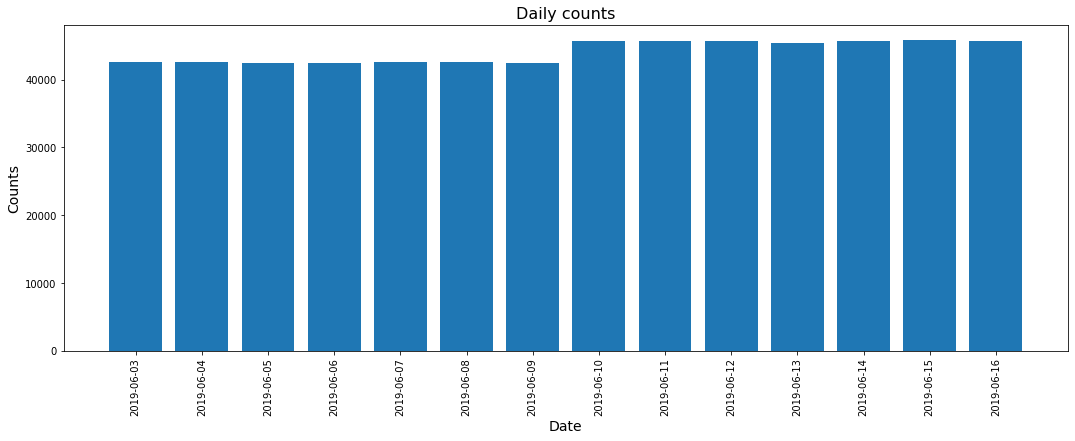

In [15]:
plt.figure(figsize=(18,6))

plt.bar(date.index, date.date)
plt.title('Daily counts', fontsize=16)
plt.ylabel('Counts', fontsize=14)
plt.xlabel('Date', fontsize=14)
plt.xticks(date.index, fontsize=10, rotation=90)

plt.show()

一日カウントは大体同じだが、2019/06/10からカウントが上がる現象がある。その理由は2019/06/10から新しい施策が施行されたためと考えられる。

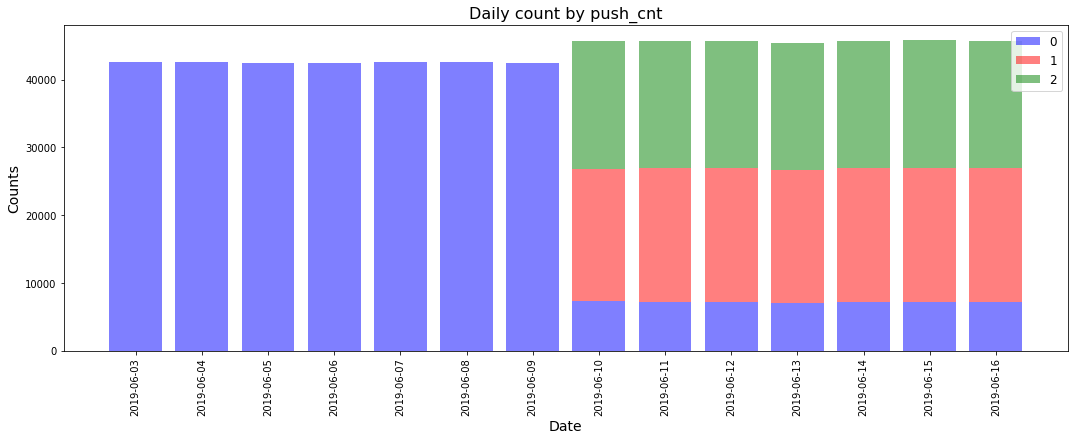

In [16]:
# divided by push count
plt.figure(figsize=(18,6))

df_0 = usr_exp[usr_exp['push_cnt'] == 0].groupby('date').count()["push_cnt"]
df_1 = usr_exp[usr_exp['push_cnt'] == 1].groupby('date').push_cnt.count().\
    reindex(usr_exp.date.unique()).fillna(0).astype(int).rename('count').reset_index()
df_2 = usr_exp[usr_exp['push_cnt'] == 2].groupby('date').push_cnt.count().\
    reindex(usr_exp.date.unique()).fillna(0).astype(int).rename('count').reset_index()
alpha = 0.5

p0 = plt.bar(df_0.index, df_0, color='b', alpha=alpha)
p1 = plt.bar(df_1['date'], df_1['count'], color='r', alpha=alpha, bottom=df_0)
p2 = plt.bar(df_2['date'], df_2['count'], color='g', alpha=alpha, bottom=df_1.\
    reset_index()['count']+df_0.reset_index()['push_cnt'])

plt.title('Daily count by push_cnt', fontsize=16)
plt.xticks(df_0.index, fontsize=10, rotation=90)
plt.ylabel('Counts', fontsize=14)
plt.xlabel('Date', fontsize=14)
plt.legend((p0[0], p1[0], p2[0]), ('0', '1', '2'), fontsize=12)

plt.show()

今度はプッシュのカウントを別に分ける。

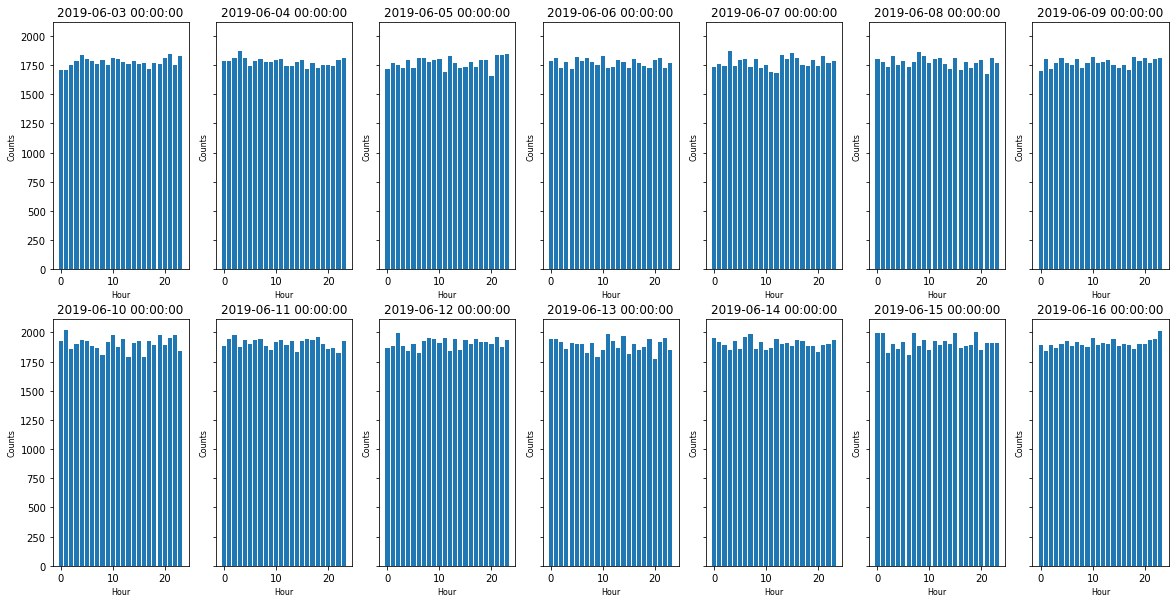

In [17]:
# divided by day
dt = usr_exp[['date','hour', "user_id"]].groupby(['date','hour']).count()
dt = dt.reset_index().set_index('date')

fig = plt.figure(figsize=(20,10))
axes = fig.subplots(nrows=2, ncols=7, sharey=True)

z = 1

for i in dt.index.unique().tolist():
  plt.subplot(2, 7, z)
  plt.title(i)
  plt.ylabel('Counts', fontsize=8)
  plt.xlabel('Hour', fontsize=8)
  day_hour_user = dt[dt.index == i]
  plt.bar(day_hour_user.hour, day_hour_user.user_id)
  z = z + 1

plt.show()

すべての時間帯で均等にユーザーが観測される。 2週目からは（新しい施策が施行される時点）比較的にすべての時間帯でログイン回数が第１週よりさらに多い。

In [18]:
usr_exp_m = usr_exp.groupby(['user_id', 'push_cnt', 'msg_type', \
    'change', 'type', 'date']).\
    size().groupby(['user_id', 'push_cnt', 'msg_type', 'change', 'type']).mean().\
        rename('mean').reset_index()

usr_exp_m

,user_id,push_cnt,msg_type,change,type,mean
0,u00000001,0,None,before,0/None/before,4.285714
1,u00000001,2,B,after,2/B/after,4.714286
2,u00000002,0,None,before,0/None/before,4.142857
3,u00000002,2,B,after,2/B/after,4.571429
4,u00000003,0,None,before,0/None/before,3.428571
...,...,...,...,...,...,...
23185,u00011593,1,A,after,1/A/after,4.857143
23186,u00011594,0,None,after,0/None/after,3.166667
23187,u00011594,0,None,before,0/None/before,2.571429
23188,u00011595,0,None,before,0/None/before,3.714286


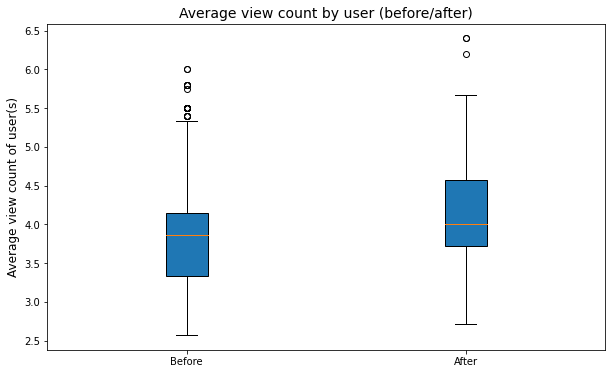

In [19]:
data_to_plot = [usr_exp_m[usr_exp_m['change']=='before']['mean'], \
    usr_exp_m[usr_exp_m['change']=='after']['mean']]

plt.figure(figsize=(10, 6))
plt.boxplot(data_to_plot,patch_artist=True,labels=['Before','After'])
plt.ylabel('Average view count of user(s)', fontsize=12)
plt.title('Average view count by user (before/after)', fontsize = 14)
plt.show()

Text(0.5, 1.0, 'Average view count by user (push message)')

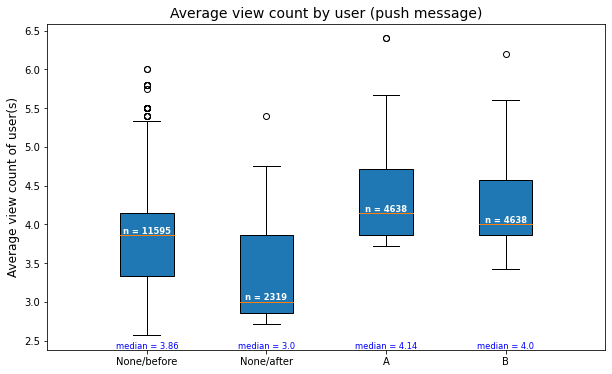

In [20]:
# prepare data
data_to_plot = [usr_exp_m[(usr_exp_m['msg_type']=='None')&(usr_exp_m['change']=='before')]['mean'], \
    usr_exp_m[(usr_exp_m['msg_type']=='None')&(usr_exp_m['change']=='after')]['mean'],\
        usr_exp_m[(usr_exp_m['msg_type']=='A')&(usr_exp_m['change']=='after')]['mean'],\
            usr_exp_m[(usr_exp_m['msg_type']=='B')&(usr_exp_m['change']=='after')]['mean']]

data_pos = [1, 1.6, 2.2, 2.8]

# Positions defaults to range(1, N+1) where N is the number of boxplot to be drawn.
# we will move them a little, to visually group them
plt.figure(figsize=(10, 6))
box = plt.boxplot(data_to_plot,
                  positions=data_pos,
                  labels=['None/before','None/after',\
                    'A',\
                      'B'],
                        patch_artist=True)

data_len = []
medians = []
for i in data_to_plot:
     data_len.append(len(i))
     medians.append(np.median(i))

for tick, i in enumerate(data_pos):
    plt.text(data_pos[tick], 
    medians[tick] + 0.03,
    "n = " + str(data_len[tick]),
    horizontalalignment='center',
    size='small',
    color='w',
    weight='semibold')

    plt.text(data_pos[tick], 
    2.4,
    "median = " + str(round(medians[tick],2)),
    horizontalalignment='center',
    size='small',
    color='b')

plt.ylabel('Average view count of user(s)', fontsize=12)
plt.title('Average view count by user (push message)', fontsize = 14)

プッシュメッセージを別に分ける。プッシュメッセージ”A"は”B"より比較的に多い。外れ値も見られる（特にプッシュを受けっていない場合）。施策前のログイン回数が意外に高い理由はログイン回数が低いユーザー、回数の高いユーザーをすべて含んでいるためと予想される。

Text(0.5, 1.0, 'Average view count by user (type of message and #)')

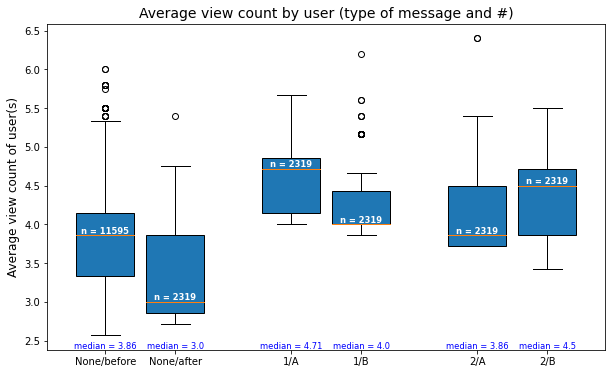

In [21]:
# prepare data
data_to_plot = [usr_exp_m[usr_exp_m['type']=='0/None/before']['mean'], \
    usr_exp_m[usr_exp_m['type']=='0/None/after']['mean'],\
        usr_exp_m[usr_exp_m['type']=='1/A/after']['mean'],\
            usr_exp_m[usr_exp_m['type']=='1/B/after']['mean'],\
                usr_exp_m[usr_exp_m['type']=='2/A/after']['mean'],\
                    usr_exp_m[usr_exp_m['type']=='2/B/after']['mean']]

data_pos = [1, 1.6, 2.6, 3.2, 4.2, 4.8]

plt.figure(figsize=(10, 6))
box = plt.boxplot(data_to_plot,
                  positions = data_pos,
                  labels=['None/before','None/after',\
                    '1/A',\
                        '1/B',\
                            '2/A', \
                                '2/B'],
                                patch_artist=True)

data_len = []
medians = []
for i in data_to_plot:
     data_len.append(len(i))
     medians.append(np.median(i))

for tick, i in enumerate(data_pos):
    plt.text(data_pos[tick], 
    medians[tick] + 0.03,
    "n = " + str(data_len[tick]),
    horizontalalignment='center',
    size='small',
    color='w',
    weight='semibold')

    plt.text(data_pos[tick], 
    2.4,
    "median = " + str(round(medians[tick],2)),
    horizontalalignment='center',
    size='small',
    color='b')

plt.ylabel('Average view count of user(s)', fontsize=12)
plt.title('Average view count by user (type of message and #)', fontsize = 14)

もう少し精密に回数でも分けてみると、メッセージAを1回受け取ったユーザーがメッセージBを1回受け取ったユーザに比べてログイン回数が高いことが見られ、メッセージAを2回受け取ったユーザーはメッセージBを2回受け取った人に比べて高い。上述のように、一般的に”A"は”B”よりログイン回数が高い。

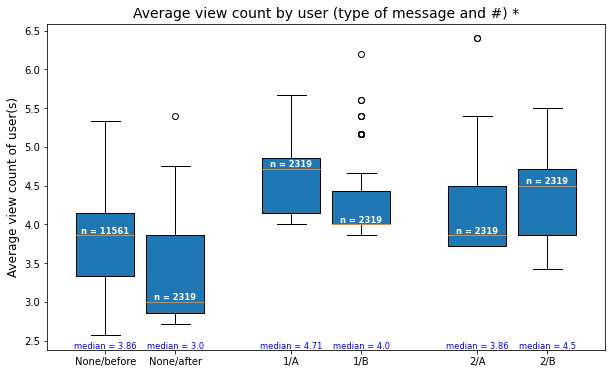

In [22]:
Q1 = usr_exp_m[usr_exp_m['type']=='0/None/before']['mean'].quantile(0.25)
Q3 = usr_exp_m[usr_exp_m['type']=='0/None/before']['mean'].quantile(0.75)
IQR = Q3 - Q1

outs = (usr_exp_m[usr_exp_m['type']=='0/None/before']['mean'] >= Q1 - 1.5 * IQR) & \
    (usr_exp_m[usr_exp_m['type']=='0/None/before']['mean'] <= Q3 + 1.5 *IQR)

# prepare data
data_to_plot = [usr_exp_m[usr_exp_m['type']=='0/None/before'].loc[outs]['mean'], \
    usr_exp_m[usr_exp_m['type']=='0/None/after']['mean'],\
        usr_exp_m[usr_exp_m['type']=='1/A/after']['mean'],\
            usr_exp_m[usr_exp_m['type']=='1/B/after']['mean'],\
                usr_exp_m[usr_exp_m['type']=='2/A/after']['mean'],\
                    usr_exp_m[usr_exp_m['type']=='2/B/after']['mean']]

plt.figure(figsize=(10, 6))
box = plt.boxplot(data_to_plot,
                  positions=[1, 1.6, 2.6, 3.2, 4.2, 4.8],
                  labels=['None/before','None/after',\
                    '1/A',\
                        '1/B',\
                            '2/A', \
                                '2/B'],
                                patch_artist=True)

data_len = []
medians = []
for i in data_to_plot:
     data_len.append(len(i))
     medians.append(np.median(i))

for tick, i in enumerate(data_pos):
    plt.text(data_pos[tick], 
    medians[tick] + 0.03,
    "n = " + str(data_len[tick]),
    horizontalalignment='center',
    size='small',
    color='w',
    weight='semibold')

    plt.text(data_pos[tick], 
    2.4,
    "median = " + str(round(medians[tick],2)),
    horizontalalignment='center',
    size='small',
    color='b')

plt.ylabel('Average view count of user(s)', fontsize=12)
plt.title('Average view count by user (type of message and #) *', fontsize = 14)

plt.show()

施策の前の外れた値（３４件）を除外するみたが、大きな差はない。

まとめると、EDAで見られた現象はログイン回数は毎日継続的に同一であり、時間帯別にも同じである。 上記のように、2週目からは新たな施策が実施され、ログイン回数が上がったと思う。施策前のログイン回数が高い理由は、ログイン回数が低いユーザー、回数の高いユーザーをすべて含んでいるためと予想される。
外れ値も見られたが、除外せずに進める。 外れ値を処理することが最適であるが、ユーザのその他の情報がないため、処理を行わない。また、外れた値の数が比較的多くないので分析から除外しない。

新たな施策がログイン回収の影響があったか確認するためには、仮設検定を行う。 仮設検定も複数の検定方法があるので、適切な検定方法を定めることも重要である。 まず、データが正規分布であるかShapiro-WilksTestで確認する。 後、正規分布であればT-testで進行し、そうでない場合はMann-WhitneyTestで進行する。下記のab_t関数に代入する場合、結果を示す。

In [23]:
shapiro_df(usr_exp_m, 'type')

/Users/jaichung/Documents/10_Work/line2/.venv/lib/python3.9/site-packages/scipy/stats/_morestats.py:1761: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


,Scenario,n,p-value,Normality?
0,0/None/before,11595,2.133356e-37,Not of normal distribution
0,2/B/after,2319,3.723250e-42,Not of normal distribution
0,2/A/after,2319,0.000000e+00,Not of normal distribution
0,0/None/after,2319,2.153095e-41,Not of normal distribution
0,1/B/after,2319,0.000000e+00,Not of normal distribution
0,1/A/after,2319,0.000000e+00,Not of normal distribution


すべての場合のデータをShapiroテストで標準分布検査をしてみたが、P-Valueが0.05以下なので仮説を棄却する。だが、施策前の場合はデータが多いので慎重に進める。

標準分布データがないため、Mann Whitneyテストに進む。

In [24]:
#Mann Whitney - pairwise
data_mw = [usr_exp_m[usr_exp_m['type']=='0/None/before'].loc[outs]['mean'], \
    usr_exp_m[usr_exp_m['type']=='1/A/after']['mean'],\
        usr_exp_m[usr_exp_m['type']=='1/B/after']['mean'],\
            usr_exp_m[usr_exp_m['type']=='2/B/after']['mean'],\
                usr_exp_m[usr_exp_m['type']=='2/A/after']['mean']]
                
mw_res = sp.posthoc_mannwhitney(data_mw)
mw_res = mw_res.set_axis(['0/None/before', '1/A/after', '1/B/after', \
    '2/B/after', '2/A/after'], axis=1, inplace=False)
mw_res = mw_res.set_axis(['0/None/before', '1/A/after', '1/B/after', \
    '2/B/after', '2/A/after'], axis=0, inplace=False)
mw_res

,0/None/before,1/A/after,1/B/after,2/B/after,2/A/after
0/None/before,1.000000e+00,0.000000e+00,5.926100e-226,1.428814e-220,2.132098e-75
1/A/after,0.000000e+00,1.000000e+00,2.509230e-263,4.405943e-133,0.000000e+00
1/B/after,5.926100e-226,2.509230e-263,1.000000e+00,1.594150e-08,7.611181e-104
2/B/after,1.428814e-220,4.405943e-133,1.594150e-08,1.000000e+00,3.267455e-59
2/A/after,2.132098e-75,0.000000e+00,7.611181e-104,3.267455e-59,1.000000e+00


Mann Whitneyテストを施策前にデータと対に分析する。その結果、すべての対のP-valueが0.05以下なので、施策前のデータと似ていないことがわかる。

だが、上記の分析の問題は施策前のデータが実験群データ（After）に比べてデータの数が多く、多様なためよくにログインするユーザ、よくにログインしないユーザの情報が全て集まっている。

解決策としてSampling（サンプリング）があるが、この課題には切り替え率（例えば、どの程度のユーザーがB画面を通じて決済をしたのか？）データを得るのが難しく、Samplingが容易ではない。

Samplingが難しいので、場合別に一部のユーザーだけに制限して施策前と施策後を分析をしてみる。

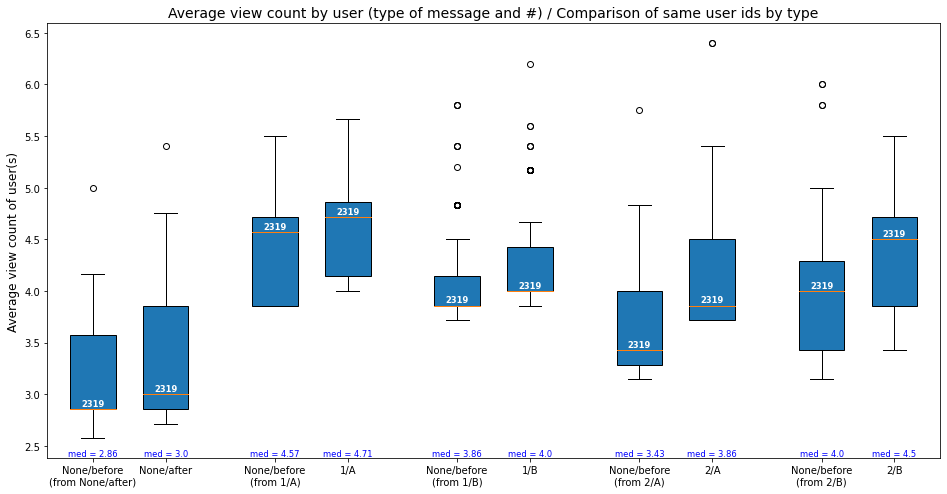

In [25]:
# prepare data
data_to_plot = [df_id(usr_exp_m, '0/None/after')['mean'], \
    usr_exp_m[usr_exp_m['type']=='0/None/after']['mean'],\
        df_id(usr_exp_m, '1/A/after')['mean'],\
        usr_exp_m[usr_exp_m['type']=='1/A/after']['mean'],\
            df_id(usr_exp_m, '1/B/after')['mean'],\
            usr_exp_m[usr_exp_m['type']=='1/B/after']['mean'],\
                df_id(usr_exp_m, '2/A/after')['mean'],\
                usr_exp_m[usr_exp_m['type']=='2/A/after']['mean'],\
                    df_id(usr_exp_m, '2/B/after')['mean'],\
                    usr_exp_m[usr_exp_m['type']=='2/B/after']['mean']]

data_pos = [1, 1.8, 3.0, 3.8, 5.0, 5.8, 7.0, 7.8, 9.0, 9.8]
plt.figure(figsize=(16, 8))
box = plt.boxplot(data_to_plot,
                  positions=data_pos,
                  labels=['None/before\n(from None/after)',\
                    'None/after',\
                    'None/before\n(from 1/A)',\
                        '1/A',\
                            'None/before\n(from 1/B)',\
                        '1/B',\
                            'None/before\n(from 2/A)',\
                            '2/A', \
                                'None/before\n(from 2/B)',\
                                '2/B'],
                                patch_artist=True)

data_len = []
medians = []
for i in data_to_plot:
     data_len.append(len(i))
     medians.append(np.median(i))

for tick, i in enumerate(data_pos):
    plt.text(data_pos[tick], 
    medians[tick] + 0.03,
    str(data_len[tick]),
    horizontalalignment='center',
    size='small',
    color='w',
    weight='semibold')

    plt.text(data_pos[tick], 
    2.4,
    "med = " + str(round(medians[tick],2)),
    horizontalalignment='center',
    size='small',
    color='b')

plt.ylabel('Average view count of user(s)', fontsize=12)
plt.title('Average view count by user (type of message and #) / Comparison of same user ids by type', fontsize = 14)

plt.show()

Samplingの代わりにプッシュメッセージを受け取るように指定されたユーザーの施策前後を直接比較してみる。例えば、None/before（from1/A）のデータのユーザは1/A（施策後）のユーザと同一であるが、施策前のデータである。グラフを見ると、施策前のデータが分散する前にログイン回数の少ないユーザー、多くのユーザーが集まっていたことがわかる。
前後に一番大きな差を見せたグループは2回プッシュを受けたユーザーたちだ。他のグループはログイン回数が比較的大きく増加しなかった。

分散したデータで分析を再度進める。

In [26]:
usr_exp_m_mod = usr_exp_m
for i in ['0/None/after', '1/A/after', '1/B/after', '2/A/after', '2/B/after']:
    i_str = 'None/before (from ' + i.rsplit('/', 1)[0] + ')'
    usr_exp_m_mod = usr_exp_m_mod.assign(type = np.where(usr_exp_m_mod['type'].eq('0/None/before') &
        usr_exp_m_mod['user_id'].isin(usr_exp_m_mod[usr_exp_m_mod['type']==i]['user_id']),
            i_str, usr_exp_m_mod['type']))

shapiro_df(usr_exp_m_mod, 'type')

,Scenario,n,p-value,Normality?
0,None/before (from 2/B),2319,3.364041e-40,Not of normal distribution
0,2/B/after,2319,3.723250e-42,Not of normal distribution
0,None/before (from 2/A),2319,3.951662e-43,Not of normal distribution
0,2/A/after,2319,0.000000e+00,Not of normal distribution
0,0/None/after,2319,2.153095e-41,Not of normal distribution
0,None/before (from 0/None),2319,5.219250e-39,Not of normal distribution
0,None/before (from 1/B),2319,0.000000e+00,Not of normal distribution
0,1/B/after,2319,0.000000e+00,Not of normal distribution
0,None/before (from 1/A),2319,0.000000e+00,Not of normal distribution
0,1/A/after,2319,0.000000e+00,Not of normal distribution


今度もすべての場合のデータをShapiroテストで標準分布検査をしてみたが、P-Valueが0.05以下なので仮説を棄却する。Mann Whitneyテストに進む。

In [27]:
# create hypothesis test table
types = [["None/before (from 0/None)", "0/None/after"], ["None/before (from 1/A)", "1/A/after"],\
        ["None/before (from 1/B)","1/B/after"], ["None/before (from 2/A)","2/A/after"],\
                ["None/before (from 2/B)","2/B/after"]]
ab_t_h = pd.DataFrame([])
for i in types:
        temp = ab_t(usr_exp_m_mod, i[0], i[1])
        ab_t_h = pd.concat((ab_t_h, temp), axis = 0)
ab_t_h

,Scenario,Test Type,AB Hypothesis,p-value,Comment
0,None/before (from 0/None) vs. 0/None/after,Non-Parametric,Reject H0,2.539908e-17,A/B groups are not similar
0,None/before (from 1/A) vs. 1/A/after,Non-Parametric,Reject H0,3.905795e-125,A/B groups are not similar
0,None/before (from 1/B) vs. 1/B/after,Non-Parametric,Reject H0,1.420771e-127,A/B groups are not similar
0,None/before (from 2/A) vs. 2/A/after,Non-Parametric,Reject H0,8.156396e-246,A/B groups are not similar
0,None/before (from 2/B) vs. 2/B/after,Non-Parametric,Reject H0,7.959924e-116,A/B groups are not similar


データ分散後の分析でもMan Whitneyテストでは、すべての場合のペアが似ていないと見ることができる。

In [28]:
# difference in mean between before/after
usr_exp_m_mod_st = pd.concat([usr_exp_m_mod.groupby(['type']).mean()[5::].reset_index(), \
    usr_exp_m_mod.groupby(['type']).mean()[0:5].reset_index()], axis = 1)
usr_exp_m_mod_st = pd.concat([usr_exp_m_mod_st, usr_exp_m_mod_st.iloc[:,5] - \
    usr_exp_m_mod_st.iloc[:,2]], axis = 1)
usr_exp_m_mod_st.columns.values[6] = 'd(mean)'
usr_exp_m_mod_st

,type,push_cnt,mean,type,push_cnt,mean,d(mean)
0,None/before (from 0/None),0.0,3.113982,0/None/after,0.0,3.235207,0.121225
1,None/before (from 1/A),0.0,4.302333,1/A/after,1.0,4.468829,0.166496
2,None/before (from 1/B),0.0,3.970118,1/B/after,1.0,4.138958,0.168839
3,None/before (from 2/A),0.0,3.588036,2/A/after,2.0,4.026844,0.438809
4,None/before (from 2/B),0.0,3.827818,2/B/after,2.0,4.199963,0.372145


最初に、データの構造および状態を調べる。分析の簡素化のために抜けているデータの前処理方法では除去する。 抜けたデータは5%程度になった。 抜けているデータの前処理方法は除去するか、それとも代入法もあるが、この課題では代入法を実施するには情報および根拠が足りないため除去した。グラフはまた、データをさらに理解できるように(2週目の時にどのように変わるのか)手伝ってくれる。

テストを行った結果、ShapiroテストはH0（帰無仮説）を棄却する。この意味は、データが正規分布（Normal distribution）ではないことを意味する。したがって、Non-parametric TestであるMann Whitney Testで進行する。Mann Whitney Testでもすべての状況でH0を棄却できると出ている。この意味と結果は、1週目とのデータと第2週目とのデータは似ていないことがわかるし、2週目から（6/10~6/16）の新た施策は効果があることを意味する。

施策前のデータが多すぎて（１１５６１件）Samplingが望ましいと思ったが、切替率データや他の情報がなくて難しかった。そうして、Samplingの代わりにプッシュメッセージを(1回や2回)受ける指定されたユーザーの前後データに分散して分析を再びしてみた。だが、これもやはりH0を棄却しなければならないという結果がでた。

結論は、ログイン回数が一番多く上がったグループは2回のメッセージを受け取ったユーザーだ。その中でもAを2回受け取ったユーザーが平均的にログイン回数がさらに増加した。テストの結果によって、他の場合にも差があることが見られた。新しい施策を施行する方向に進むのが正しいが、後述する点を理解し分析を再度行うのがより正確だと思う。

課題の過程で発見した点があった。最初に、外れ値を処理するの他の情報なかった。すべてのデータから５％のみを占めているので除外する方法を選択肢しましたが、十分な情報がある場合に（例：他のColumnのデータ）代入法の方法もある。また、プッシュメッセージを受け取るユーザを指定される手続きでBiasが生じたと考える。プッシュメッセージを受け取るように指定されたユーザーの施策前後を直接比較したときのグラフを描いてみた（グラフの題目：Average view count by user (type of message and #) / Comparison of same user ids by type）。一般的にSampling（あるいはユーザ指定）がうまくいった場合、すべての場合に分布と中間値が似ていると予想する。だが、対照群のユーザ、プッシュメッセージAを１回受け取ったユーザの施策前、プッシュメッセージAを２回受け取ったユーザの施策前、プッシュメッセージBを１回受け取ったユーザ、プッシュメッセージBを２回受け取ったユーザの施策前の分布と中間値が互いに似ていない（例：プッシュメッセージAを１回受け取ったユーザの分布が対照群と異なり、中間値は対照群より比較的にとても高い）。